In [278]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [279]:
table = pd.read_csv('train.csv')
# table.info()
table.isna().sum()

ApplicationDate                530
Age                            530
AnnualIncome                   530
CreditScore                   1031
LoanAmount                    1031
LoanDuration                   530
MaritalStatus                  530
NumberOfDependents             530
HomeOwnershipStatus            530
MonthlyDebtPayments           1031
CreditCardUtilizationRate      530
NumberOfOpenCreditLines        530
NumberOfCreditInquiries        530
DebtToIncomeRatio              530
BankruptcyHistory             1031
LoanPurpose                   1031
PreviousLoanDefaults           530
PaymentHistory                 530
LengthOfCreditHistory          530
SavingsAccountBalance          530
CheckingAccountBalance        1031
TotalAssets                   1031
TotalLiabilities               530
MonthlyIncome                  530
UtilityBillsPaymentHistory     530
JobTenure                      530
EmploymentStatus               530
EducationLevel                 530
Experience          

<Axes: >

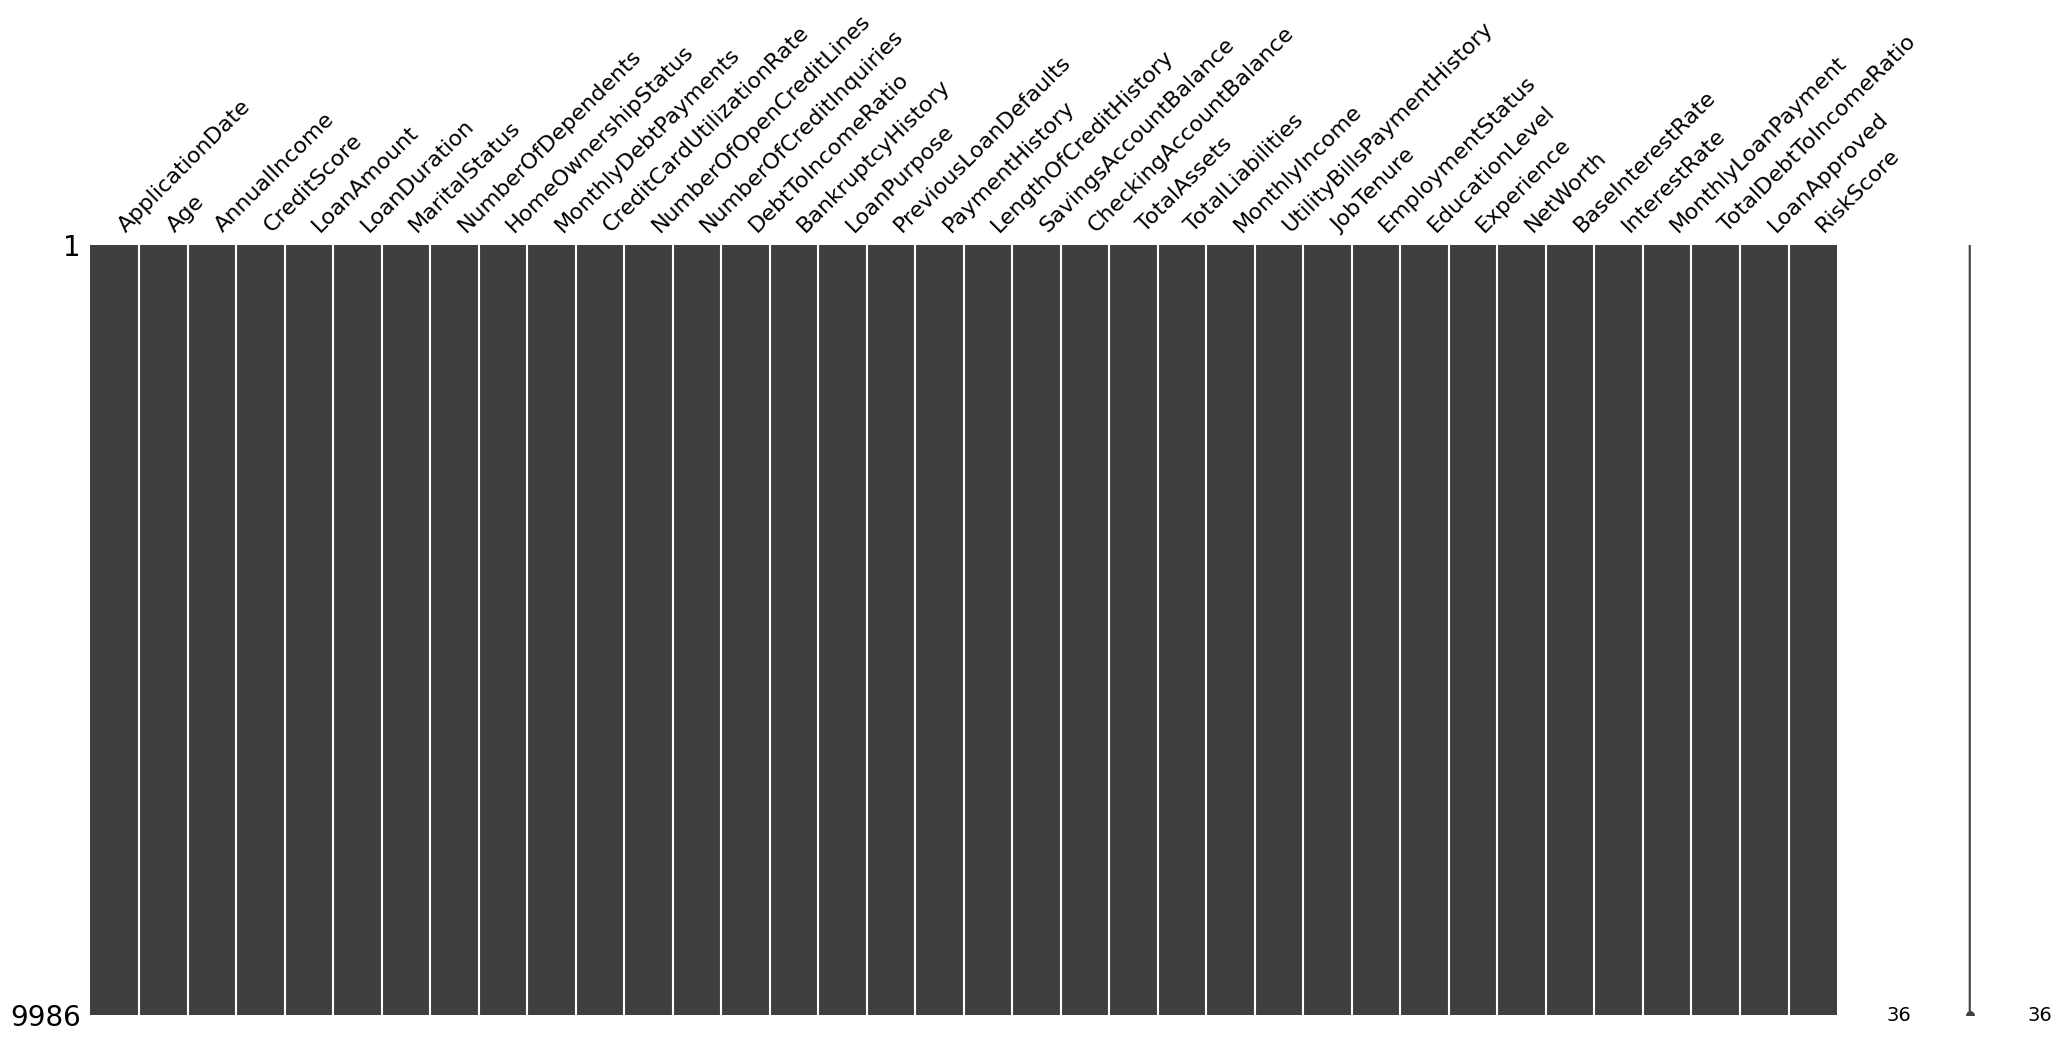

In [280]:
import missingno as msno

table = table.dropna(how='any')

msno.matrix(table)

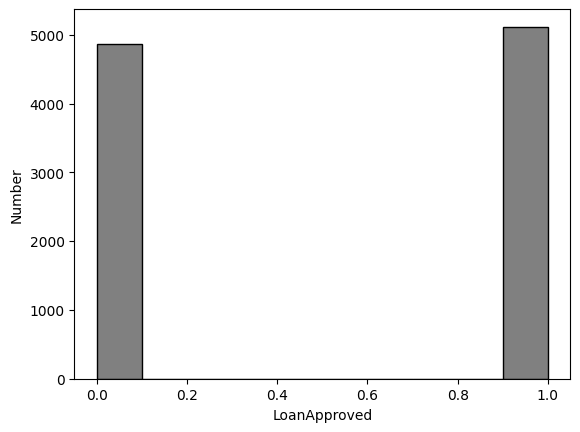

In [281]:
plt.hist(table['LoanApproved'], color='gray', edgecolor='black',)
plt.xlabel('LoanApproved')
plt.ylabel('Number')
plt.show()

In [282]:
# fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 20)) 

int_columns = []

risk = table['LoanApproved']

for x in table.columns:
    if not(type(table[x][1]) == str):
        int_columns.append(x)

# for i, col in enumerate(int_columns):

#     row = i // 4
#     col_idx = i % 4
#     ax = axes[row, col_idx]

#     ax.scatter(risk, table[col], color='purple', edgecolors='black')
#     ax.set_title(f'{col} vs. LoanApproved')
#     ax.set_xlabel('LoanApproved')
#     ax.set_ylabel(f'{col}')
#     ax.grid(True)

int_columns.remove('MonthlyIncome')
int_columns.remove('RiskScore')
final_cats = int_columns

# plt.tight_layout() 
# plt.show()

Сошлось на итерации 1310
Accuracy на валидационных данных: 0.9354354354354354
Precision на валидационных данных: 0.9431929480901078
Recall на валидационных данных: 0.9313346228239845
F1-metric на валидационных данных: 0.9372262773722628


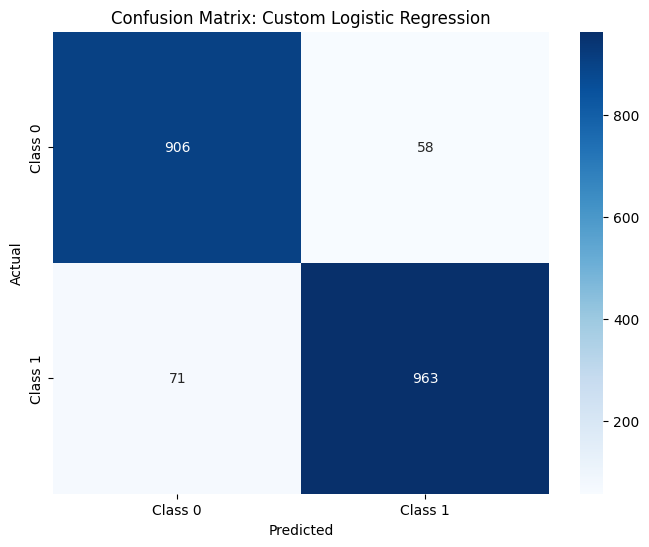

In [283]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

class LogisticRegressionCustom:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=0.01):
        """
        Параметры:
        - learning_rate: скорость обучения (по умолчанию 0.01)
        - max_iter: максимальное количество итераций (по умолчанию 1000)
        - tol: критерий сходимости (по умолчанию 1e-4)
        """
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        """Сигмоидная функция."""
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """
        Обучение модели методом градиентного спуска.

        Параметры:
        - X: матрица признаков, размерность (n_samples, n_features)
        - y: вектор целевой переменной, размерность (n_samples,)
        """
        n_samples, n_features = X.shape
        
        # Инициализация весов и смещения
        self.weights = np.zeros(n_features)
        self.bias = 0

        for i in range(self.max_iter):
            # Линейная комбинация входных данных и весов
            linear_model = np.dot(X, self.weights) + self.bias
            # Применение сигмоидной функции
            predictions = self.sigmoid(linear_model)

            # Вычисление градиентов
            dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
            db = (1 / n_samples) * np.sum(predictions - y)

            # Обновление весов и смещения
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Проверка на сходимость
            # print(np.linalg.norm(dw), abs(db),  self.tol)
            if np.linalg.norm(dw) < self.tol and abs(db) < self.tol:
                print(f"Сошлось на итерации {i}")
                break

    def predict_proba(self, X):
        """
        Возвращает вероятность принадлежности к положительному классу.

        Параметры:
        - X: матрица признаков, размерность (n_samples, n_features)

        Возвращает:
        - probabilities: массив вероятностей, размерность (n_samples,)
        """
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        """
        Предсказание класса (0 или 1) на основе вероятностей.

        Параметры:
        - X: матрица признаков, размерность (n_samples, n_features)
        - threshold: порог для классификации (по умолчанию 0.5)

        Возвращает:
        - predictions: массив предсказанных классов (0 или 1), размерность (n_samples,)
        """
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

# Основная часть кода
if __name__ == "__main__":
    test_data = pd.read_csv('test.csv')
    table = table[final_cats]

    # Разделение признаков и целевой переменной
    X = table.drop(columns=['LoanApproved'])  # Удаляем целевую переменную
    y = table['LoanApproved']                 # Целевая переменная

    # Разделение тренировочного датасета на обучающую и валидационную выборки
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Масштабирование данных
    final_cats.remove('LoanApproved')
    test_data = test_data[final_cats]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = test_data[final_cats]
    X_test = scaler.transform(test_data)

    # Обучение модели
    model = LogisticRegressionCustom(learning_rate=0.1, max_iter=2000)
    model.fit(X_train, y_train)

    # Оценка модели на валидационных данных
    y_val_pred = model.predict(X_val)
    print("Accuracy на валидационных данных:", accuracy_score(y_val, y_val_pred))
    print("Precision на валидационных данных:", precision_score(y_val, y_val_pred))
    print("Recall на валидационных данных:", recall_score(y_val, y_val_pred))
    print("F1-metric на валидационных данных:", f1_score(y_val, y_val_pred))

    plot_confusion_matrix(y_val, y_val_pred, "Confusion Matrix: Custom Logistic Regression")

Model: Logistic Regression
Accuracy: 0.9349
Precision: 0.9414
Recall: 0.9323
F1 Score: 0.9368
------------------------------


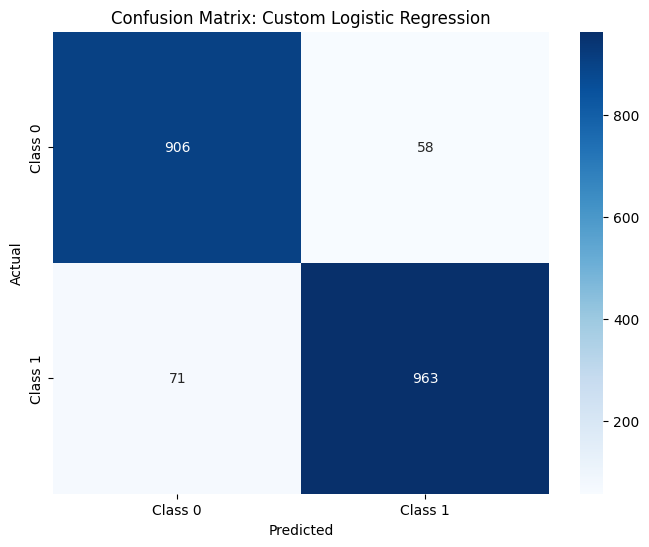

Model: SVM
Accuracy: 0.9339
Precision: 0.9430
Recall: 0.9284
F1 Score: 0.9357
------------------------------


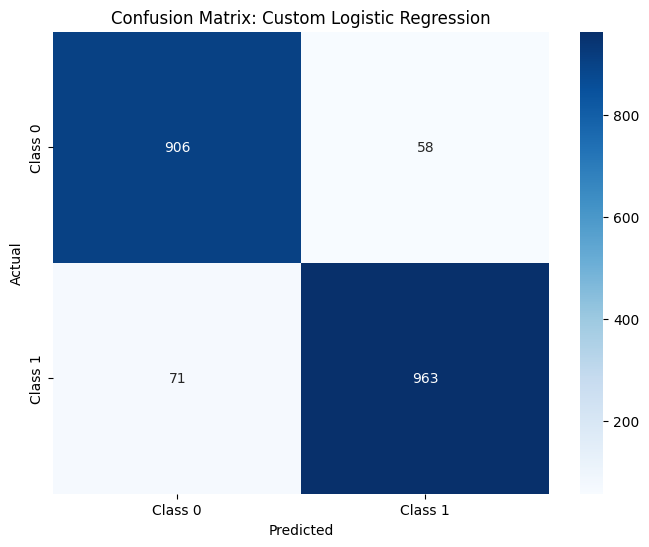

Model: Decision Tree
Accuracy: 0.8999
Precision: 0.9056
Recall: 0.9004
F1 Score: 0.9030
------------------------------


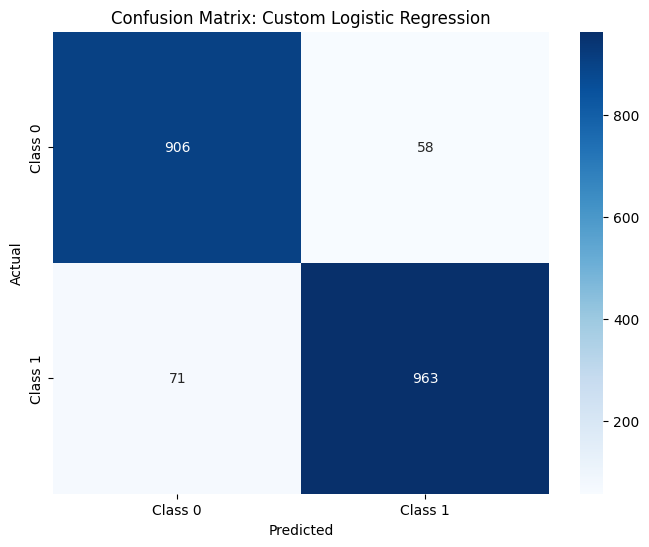

Model: Random Forest
Accuracy: 0.9339
Precision: 0.9345
Recall: 0.9381
F1 Score: 0.9363
------------------------------


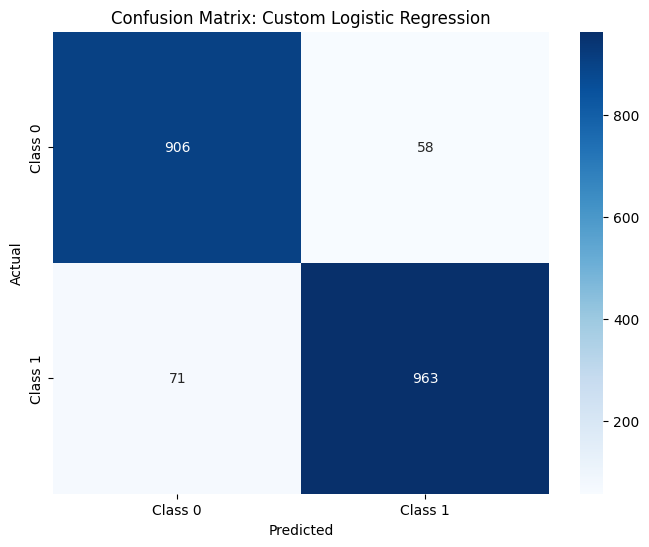

Model: Gradient Boosting
Accuracy: 0.9329
Precision: 0.9344
Recall: 0.9362
F1 Score: 0.9353
------------------------------


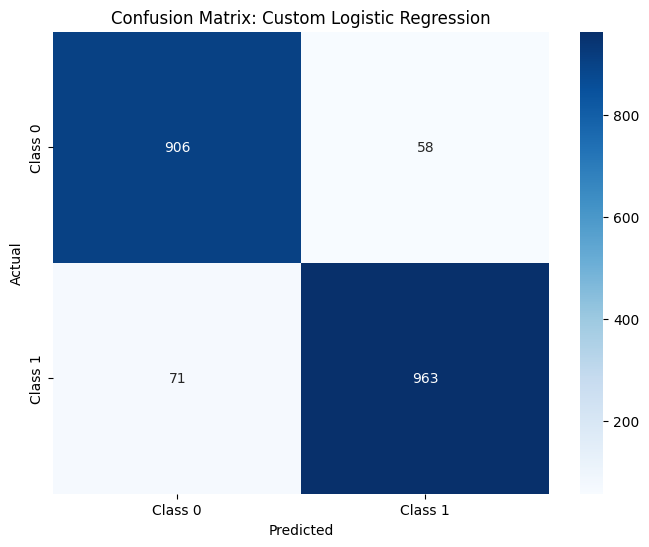

[LightGBM] [Info] Number of positive: 4082, number of negative: 3906
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4308
[LightGBM] [Info] Number of data points in the train set: 7988, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511017 -> initscore=0.044073
[LightGBM] [Info] Start training from score 0.044073
Model: LightGBM
Accuracy: 0.9369
Precision: 0.9399
Recall: 0.9381
F1 Score: 0.9390
------------------------------


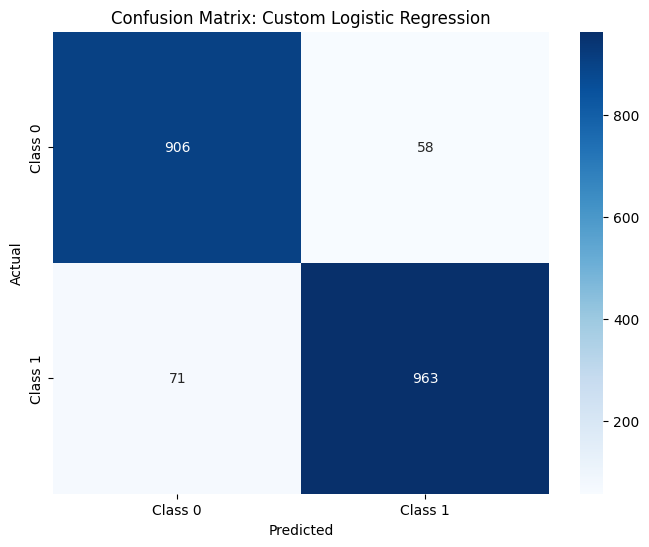

Model: XGBoost
Accuracy: 0.9379
Precision: 0.9417
Recall: 0.9381
F1 Score: 0.9399
------------------------------


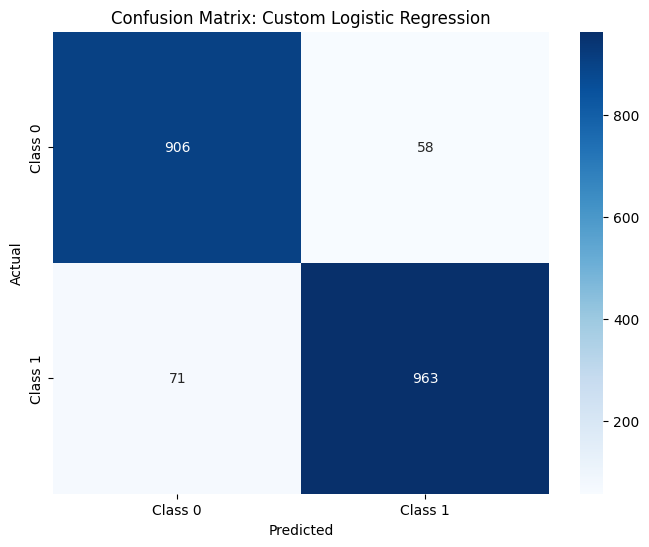

Model: CatBoost
Accuracy: 0.9384
Precision: 0.9435
Recall: 0.9371
F1 Score: 0.9403
------------------------------


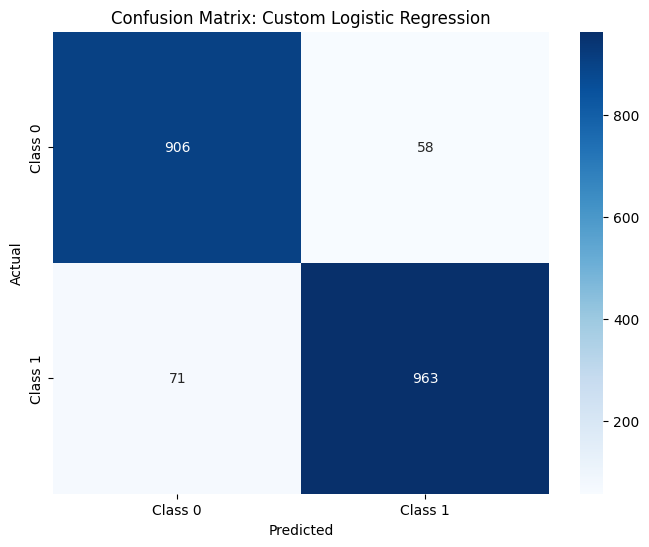

In [284]:
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "LightGBM": lgb.LGBMClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "CatBoost": cb.CatBoostClassifier(verbose=0)
}

# Обучение и оценка моделей
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 30)
    plot_confusion_matrix(y_val, y_val_pred, "Confusion Matrix: Custom Logistic Regression")

Подводя итог полученных результатов, стоит сказать следующее. Моя модель неплохо справилась с предсказанием переменной LoanApproved и соответственно с решением задачи. Это подтверждается как значениями метрик, так и структурой матрицы ошибок. 

Что касается самих метрик, то значение общей точности Accuracy в большинстве случаев составила около 93% (за исключением DecisionTree, который в целом справился с задачей хуже остальных). Результат Accuracy для моей логистической регрессии составил 93.54% - что не намного выше некоторых показателей Accuracy других методов. Это говорит о том, что моя модель правильно классифицирует объекты в целом, не отставая, а то и опережая уже существующие методы. Precision для положительного класса в среднем равен 94%, что означает, что большинство объектов, предсказанных как положительные (класс 1), действительно являются положительными. Моя модель здесь также справилась довольно неплохо. Метрика Recall составляет 93%. Модель успешно идентифицировала большую часть объектов положительного класса, пропустив лишь ~7% из них. Как раз она и является, на мой взгляд, самой информативной, поскольку ключевой задачей могло быть минимизировать пропущенные случаи положительного класса (1). Наконец, F1-Score тоже равен ~93%. Данная метрика является средним гармоническим между Precision и Recall. Если одна из этих метрик будет низкой, то и F1-Score тоже снизится. В моём случае и метрика Precision, и Recall находятся на уровне 93%, соответственно и F1-Score довольно велик


Что же касается графического представления результатов, то ложные срабатывания (FP) везде составляют всего 58 случаев, что относительно мало по сравнению с общим объёмом данных, хотя число ложных отрицательных значений (FN) немного больше — 71 случай. Но в целом приемлемо :3